# Barrier method

<i>minimize</i> $f(x)=-\sum_{i=1}^{n}log(x_i)$ <br>
<i>subject to</i> $Ax=b$ <br>
<i>additional constraints:</i> $x\geq{0}$ <br>

Введем логарифмический барьер: <br>
$x\geq{0} ⇒ f_i(x)=1-x_i\leq{0}$ <br>
$\phi(x)=-\frac{1}{t}\sum_{i=1}^{m}log(-f_i(x))=-\frac{1}{t}\sum_{i=1}^{m}log(x_i-1)$

Новая задача:
<i>minimize</i> $f_b(x)=-\sum_{i=1}^{n}log(x_i)-\frac{1}{t}\sum_{i=1}^{m}log(x_i-1)$ <br>
<i>subject to</i> $Ax=b$ <br>

$f(x)$ и $\phi(x)$ являются выпуклыми как суммы выпуклых функций, аналогично $f_b(x) = f(x)+\phi(x)$ является выпуклой при фиксированном $t>0$. Ограничение $Ax=b$ задаёт аффинное множество, которое всегда является выпуклым. Таким образом, задача является **выпуклой**.

## Для каждого значения размерности $n ∈ {10,20,...,100}$ сгенерируйте $N = 100$ тестовых примеров В каждом случае найдите глобальный минимум, $x^* ∈ R^n$, с помощью CVX

In [210]:
import numpy as np
import cvxpy as cp
from tqdm import tqdm
import time
from scipy.linalg import null_space
import pickle
import os

In [162]:
rseed = 45
np.random.seed(rseed)

def generate_problem(n, seed=None):
    """
    Генерирует задачу для оптимизации.

    Параметры:
    ----------
    n: Размерность искомого вектора x ∈ ℝⁿ.
    seed: Значение для инициализации генератора случайных чисел (для воспроизводимости).

    Возвращает:
    -----------
    A: Матрица ограничений, с m = floor(n / 5) строк.
    b: Вектор правой части, вычисленный как b = A @ x_true.
    x_true: Генерируемая допустимая точка (гарантированно положительная).
    """

    rng = np.random.default_rng(seed)

    """
    Размерность m выбирается как n // 5, чтобы гарантировать наличие ненулевого ядра у A (m < n),
    что важно при генерации допустимых начальных точек через сдвиг вдоль ядра A.
    """
    m = n // 5
    A = rng.uniform(0, 100, size=(m, n))  # случайная матрица A ∈ ℝ^(m×n)

    x_true = rng.uniform(1.1, 50.0, size=n)  # гарантированно x_i > 0
    b = A @ x_true  # правая часть системы Ax = b

    return A, b, x_true


def solve_problem(A, b):
    """
    Решает задачу выпуклой оптимизации.

    Параметры:
    ----------
    A: Матрица линейных ограничений.
    b: Правая часть системы ограничений A x = b.

    Возвращает:
    -----------
    x_opt: Оптимальное решение x*, если найдено. Иначе — None.
    f_opt: Оптимальное значение целевой функции f(x*) = -∑ log(x_i). Иначе — None
    """

    n = A.shape[1]
    x = cp.Variable(n)

    # Целевая функция: максимизировать сумму логарифмов
    objective = cp.Minimize(-cp.sum(cp.log(x)))

    # Ограничения: линейная система A x = b
    constraints = [A @ x == b, x >= 1]

    # Определяем и решаем задачу
    prob = cp.Problem(objective, constraints)
    prob.solve()

    # Обработка случая, если задача не имеет допустимого решения
    if prob.status in ["infeasible", "unbounded"]:
        return None, None

    return x.value, prob.value

In [163]:
# Размерности задач
dimensions = range(10, 101, 10)

# Число задач на каждую размерность
N = 100

a_generated = {n_val:[] for n_val in dimensions} # Список матриц A для каждой размерности
b_generated = {n_val:[] for n_val in dimensions} # Список векторов b
x_true_generated = {n_val:[] for n_val in dimensions} # Истинные допустимые решения (для генерации b)
cvx_opts = {n_val:[] for n_val in dimensions} # Оптимальные значения f(x*) через CVXPY
cvx_time = {n_val:[] for n_val in dimensions}  # Время решения каждой задачи

for n in dimensions:
    for _ in tqdm(range(N), desc=f"Processing N = {n}"):
        # 1. Генерация задачи: A, b, x_true (гарантированно x_true > 0, b = A @ x_true)
        A, b, x_true = generate_problem(n)

        # 2. Решение через CVXPY + замер времени
        start_time = time.time()
        x_star, min_value = solve_problem(A, b)
        elapsed_time = time.time() - start_time

        # 3. Проверка на корректность решения
        if x_star is None:
            print("The problem is infeasible or unbounded.")
            continue

        # 4. Сохраняем результаты
        a_generated[n].append(A)
        b_generated[n].append(b)
        x_true_generated[n].append(x_true)
        cvx_opts[n].append(min_value)
        cvx_time[n].append(elapsed_time)

print("\nDone")

Processing N = 10:   0%|          | 0/100 [00:00<?, ?it/s]

Processing N = 100: 100%|██████████| 100/100 [00:00<00:00, 117.43it/s]


Done


# Метод барьеров

In [164]:
def primal_obj(x):
    """
    Целевая функция f(x) = -∑ log(x_i).
    Предполагается, что все компоненты x_i > 0.
    """
    return -np.sum(np.log(x))

def barrier_obj(x, t):
    return -np.sum(np.log(x)) - (1/t) * np.sum(np.log(x - 1))

def barrier_grad(x, t):
    return -1 / x - 1.0 / (x - 1) * (1/t)

def barrier_hess(x, t):
    return np.diag(1 / x**2 + 1.0 / (x - 1)**2 * (1/t))

In [165]:
def generate_newton_starts(A: np.ndarray,
                           x_true: np.ndarray,
                           num_starts: int = 5,
                           alpha_max: float = 30,
                           seed: int = None) -> np.ndarray:
    """
    Генерирует начальные точки для метода Ньютона.

    Параметры:
    -----------
    A: Матрица линейных ограничений, предполагается m < n (ядро ненулевое).
    x_true: Допустимая точка, такая что A @ x_true = b и x_true > 0.
    num_starts:  Сколько начальных точек сгенерировать.
    alpha_max:  Верхняя граница для случайного коэффициента alpha.
    seed: Значение для генератора случайных чисел (для воспроизводимости).

    Возвращает:
    -----------
    starts:  Массив начальных точек x_start, пригодных для запуска метода Ньютона. Каждая из них удовлетворяет A x = b и x > 0.

    Исключения:
    -----------
    ValueError: Если ядро матрицы A пусто (m ≥ n), генерация невозможна.

    Примечание:
    -----------
    Генерация основана на сдвиге вдоль базиса ядра A: поскольку A @ k = 0, то A @ (x_true + α * k) = A @ x_true = b — сохраняется допустимость.
    x_start = x_true + α * k,
    где:
      - k — случайный вектор из ядра матрицы A (k ∈ ker(A)),
      - α ~ Uniform(0, alpha_max),
      - x_start > 0 — компонентно положительный.

    """
    rng = np.random.default_rng(seed)

    # Находим базис ядра матрицы A (размерность r = n - rank(A))
    U = null_space(A)  # U.shape = (n, r)
    if U.shape[1] == 0:
        raise ValueError("У матрицы A нет ненулевого ядра. Требуется m < n.")

    starts = []

    while len(starts) < num_starts:
        # Выбираем случайный вектор из базиса ядра
        j = rng.integers(U.shape[1])
        k = U[:, j]  # k ∈ ker(A)

        # Случайное масштабирование вдоль направления ядра
        alpha = rng.uniform(0, alpha_max)

        # Сдвигаем x_true вдоль направления ядра
        x_candidate = x_true + alpha * k

        # Проверка: все компоненты должны остаться положительными
        if np.all(x_candidate > 1):
            starts.append(x_candidate)

    return np.array(starts)

In [166]:
def solve_newton(x_init, A, b, f_opt, t=1, max_iters=1000, eps=1e-2, return_history=False):
    """
    Прямой метод Ньютона для задачи.

    Параметры:
    -----------
      x_init: Начальная точка, удовлетворя A x_init = b, x_init > 0.
      A, b: Данные задачи: A (m×n), b (m,).
      f_opt: Известное оптимальное значение f(x*).
      max_iters: Максимально допустимое число итераций метода.
      eps: Требуемая точность по функции: |f(x) - f_opt| < eps.
      return_history: Возвращать ли историю ошибок (|f(x) - f_opt|) по итерациям.

    Возвращает:
    -----------
      x: Найденное решение.
      f_val: Значение f(x) на полученном решении.
      err:  Итоговая погрешность |f_val - f_opt|.
      iters: Число фактически выполненных итераций (<= max_iters).
      history: История ошибки (|f(x_k) - f_opt|) по итерациям, если return_history=True.
    """

    # Делаем копию x_init
    x = x_init.copy()

    # Определяем размерность
    n, m = x.size, A.shape[0]

    # Начальное значение ошибки
    prec_history = []
    current_err = abs(barrier_obj(x, t) - f_opt)
    prec_history.append(current_err)

    # Параметры для backtracking line search (из книги)
    alpha = 0.1
    beta = 0.5

    for k in range(max_iters):
        # 1) Вычисляем градиент и гессиан
        grad = barrier_grad(x, t)
        hess = barrier_hess(x, t)

        # 2) Формируем KKT-систему
        KKT = np.block([
            [hess, A.T],
            [A,    np.zeros((m, m))]
        ])
        rhs = np.hstack([-grad, np.zeros(m)])

        # 3) Решаем KKT
        sol = np.linalg.solve(KKT, rhs)
        dx = sol[:n]

        # 4) Backtracking line search
        f_val = barrier_obj(x, t)
        gdx = grad @ dx # скалярное произведение grad(x) · dx

        t = 1.0
        success = False
        for _ in range(20):
            x_new = x + t*dx

            # Проверяем, что остаёмся в области x > 0
            if np.all(x_new > 1):
                f_new = primal_obj(x_new)
                if f_new <= f_val + alpha * t * gdx:
                    success = True
                    break
            t *= beta

        # Если ни один шаг не подошёл — останавливаемся
        if not success:
            break

        # Обновляем x
        x = x_new

        # 5) Считаем новую ошибку
        current_err = abs(primal_obj(x) - f_opt)
        if return_history:
            prec_history.append(current_err)

        # 6) Проверяем достижение требуемой точности
        if current_err < eps:
            break

    if return_history:
        return x, primal_obj(x), current_err, k + 1, prec_history
    else:
        return x, primal_obj(x), current_err, k + 1

In [225]:
def barrier_method(x_init, A, b, f_opt, mu, t0=1, eps=1e-2, max_inner_iters=50, return_history=False):
    x = x_init.copy()
    t = t0
    history = []

    barrier_iters = 0
    while True:
        barrier_iters += 1
        # print(f'Barrier method iter {barrier_iters}')
        # Минимизируем барьерную функцию методом Ньютона
        x, f_val, err, iters = solve_newton(x, A, b, f_opt, t, max_iters=max_inner_iters)
        history.append((t, f_val, err))
        # print(err)

        if len(history) > 1 and err < eps:
            break
        t *= mu  # увеличиваем t
    
    if return_history:
        return x, f_val, err, barrier_iters, history

    return x, f_val, err, barrier_iters

In [229]:
if os.path.exists('data/lab4/data.pkl'):
    with open('data/lab4/data.pkl', 'rb') as fin:
        lab4_data = pickle.load(fin)
    mu_barrier_opts = lab4_data['mu_barrier_opts']
    mu_barrier_eps = lab4_data['mu_barrier_eps']
    mu_barrier_time = lab4_data['mu_barrier_time']
    mu_barrier_iters = lab4_data['mu_barrier_iters']

In [ ]:
mu_list = [2, 10, 50, 100]

mu_barrier_opts = {}
mu_barrier_eps = {}
mu_barrier_time = {}
mu_barrier_iters = {}

for mu in mu_list:
    print('----------------')
    print(f'MU = {mu}')

    barrier_opts  = {n: [] for n in dimensions}  # Средние значения f(x*) для каждой размерности
    barrier_eps   = {n: [] for n in dimensions}  # Средние ошибки |f(x) - f_opt|
    barrier_time  = {n: [] for n in dimensions}  # Среднее время (сек) на одну точку
    barrier_iters = {n: [] for n in dimensions}  # Среднее число итераций
    data_for_graph = {}                         # Подробные результаты для анализа

    for n in dimensions:
        data_for_graph[n] = {}
        print(f"Processing n = {n}")

        for i in tqdm(range(N)):
            data_for_graph[n][i] = {}

            # --- Заранее сгенерированные данные ---
            A = a_generated[n][i]
            b = b_generated[n][i]
            x_true = x_true_generated[n][i]
            cvx_opt = cvx_opts[n][i]

            # --- Генерация N допустимых стартов x_init ---
            x_inits = generate_newton_starts(A, x_true, num_starts=N, alpha_max=1000, seed=rseed)

            num_iter = 0
            total_eps = 0
            total_min_value = 0

            # --- Запускаем метод Ньютона для каждого старта ---
            start_time = time.time()

            for idx, x in enumerate(x_inits):
                x_star, min_value, eps, iters = barrier_method(x, A, b, cvx_opt, mu=mu, t0=1)
                num_iter += iters
                total_eps += eps
                total_min_value += min_value

                data_for_graph[n][i][idx] = {
                    'iter': iters,
                    'eps': eps,
                    'min_value': min_value
                }

            elapsed_time = time.time() - start_time

            # --- Сохраняем среднюю статистику по задаче ---
            barrier_time[n].append(elapsed_time / N)
            barrier_iters[n].append(num_iter / N)
            barrier_eps[n].append(total_eps / N)
            barrier_opts[n].append(total_min_value / N)
            
    mu_barrier_opts[mu] = barrier_opts
    mu_barrier_eps[mu] = barrier_eps
    mu_barrier_time[mu] = barrier_time
    mu_barrier_iters[mu] = barrier_iters


----------------
MU = 2
Processing n = 10


100%|██████████| 100/100 [00:39<00:00,  2.56it/s]


Processing n = 20


100%|██████████| 100/100 [01:46<00:00,  1.07s/it]


Processing n = 30


100%|██████████| 100/100 [01:47<00:00,  1.07s/it]


Processing n = 40


100%|██████████| 100/100 [01:51<00:00,  1.11s/it]


Processing n = 50


100%|██████████| 100/100 [02:11<00:00,  1.32s/it]


Processing n = 60


100%|██████████| 100/100 [02:14<00:00,  1.34s/it]


Processing n = 70


100%|██████████| 100/100 [02:35<00:00,  1.56s/it]


Processing n = 80


100%|██████████| 100/100 [02:42<00:00,  1.62s/it]


Processing n = 90


100%|██████████| 100/100 [03:05<00:00,  1.85s/it]


Processing n = 100


100%|██████████| 100/100 [03:18<00:00,  1.99s/it]


----------------
MU = 10
Processing n = 10


100%|██████████| 100/100 [00:24<00:00,  4.10it/s]


Processing n = 20


100%|██████████| 100/100 [00:57<00:00,  1.74it/s]


Processing n = 30


100%|██████████| 100/100 [01:00<00:00,  1.64it/s]


Processing n = 40


100%|██████████| 100/100 [01:12<00:00,  1.38it/s]


Processing n = 50


100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Processing n = 60


100%|██████████| 100/100 [01:34<00:00,  1.06it/s]


Processing n = 70


100%|██████████| 100/100 [01:30<00:00,  1.11it/s]


Processing n = 80


100%|██████████| 100/100 [01:44<00:00,  1.04s/it]


Processing n = 90


100%|██████████| 100/100 [01:58<00:00,  1.18s/it]


Processing n = 100


100%|██████████| 100/100 [02:04<00:00,  1.24s/it]


----------------
MU = 50
Processing n = 10


100%|██████████| 100/100 [00:21<00:00,  4.66it/s]


Processing n = 20


100%|██████████| 100/100 [00:52<00:00,  1.91it/s]


Processing n = 30


100%|██████████| 100/100 [01:00<00:00,  1.66it/s]


Processing n = 40


100%|██████████| 100/100 [01:03<00:00,  1.57it/s]


Processing n = 50


100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


Processing n = 60


100%|██████████| 100/100 [01:14<00:00,  1.35it/s]


Processing n = 70


100%|██████████| 100/100 [01:29<00:00,  1.12it/s]


Processing n = 80


100%|██████████| 100/100 [01:38<00:00,  1.01it/s]


Processing n = 90


100%|██████████| 100/100 [01:37<00:00,  1.02it/s]


Processing n = 100


100%|██████████| 100/100 [01:56<00:00,  1.17s/it]


----------------
MU = 100
Processing n = 10


100%|██████████| 100/100 [00:21<00:00,  4.69it/s]


Processing n = 20


100%|██████████| 100/100 [00:45<00:00,  2.18it/s]


Processing n = 30


100%|██████████| 100/100 [00:54<00:00,  1.83it/s]


Processing n = 40


100%|██████████| 100/100 [01:01<00:00,  1.61it/s]


Processing n = 50


100%|██████████| 100/100 [01:13<00:00,  1.36it/s]


Processing n = 60


100%|██████████| 100/100 [01:13<00:00,  1.36it/s]


Processing n = 70


100%|██████████| 100/100 [01:22<00:00,  1.22it/s]


Processing n = 80


100%|██████████| 100/100 [01:31<00:00,  1.10it/s]


Processing n = 90


100%|██████████| 100/100 [01:43<00:00,  1.03s/it]


Processing n = 100


100%|██████████| 100/100 [01:49<00:00,  1.09s/it]


In [227]:
#save data if needed
lab4_data = {
    'a_generated': a_generated,
    'b_generated': b_generated,
    'x_true_generated': x_true_generated,
    'cvx_opts': cvx_opts,
    'cvx_time': cvx_time,
    'mu_barrier_opts': mu_barrier_opts,
    'mu_barrier_eps': mu_barrier_eps,
    'mu_barrier_time': mu_barrier_time,
    'mu_barrier_iters': mu_barrier_iters
}

with open('data/lab4/data.pkl', 'wb') as fout:
    pickle.dump(lab4_data, fout)

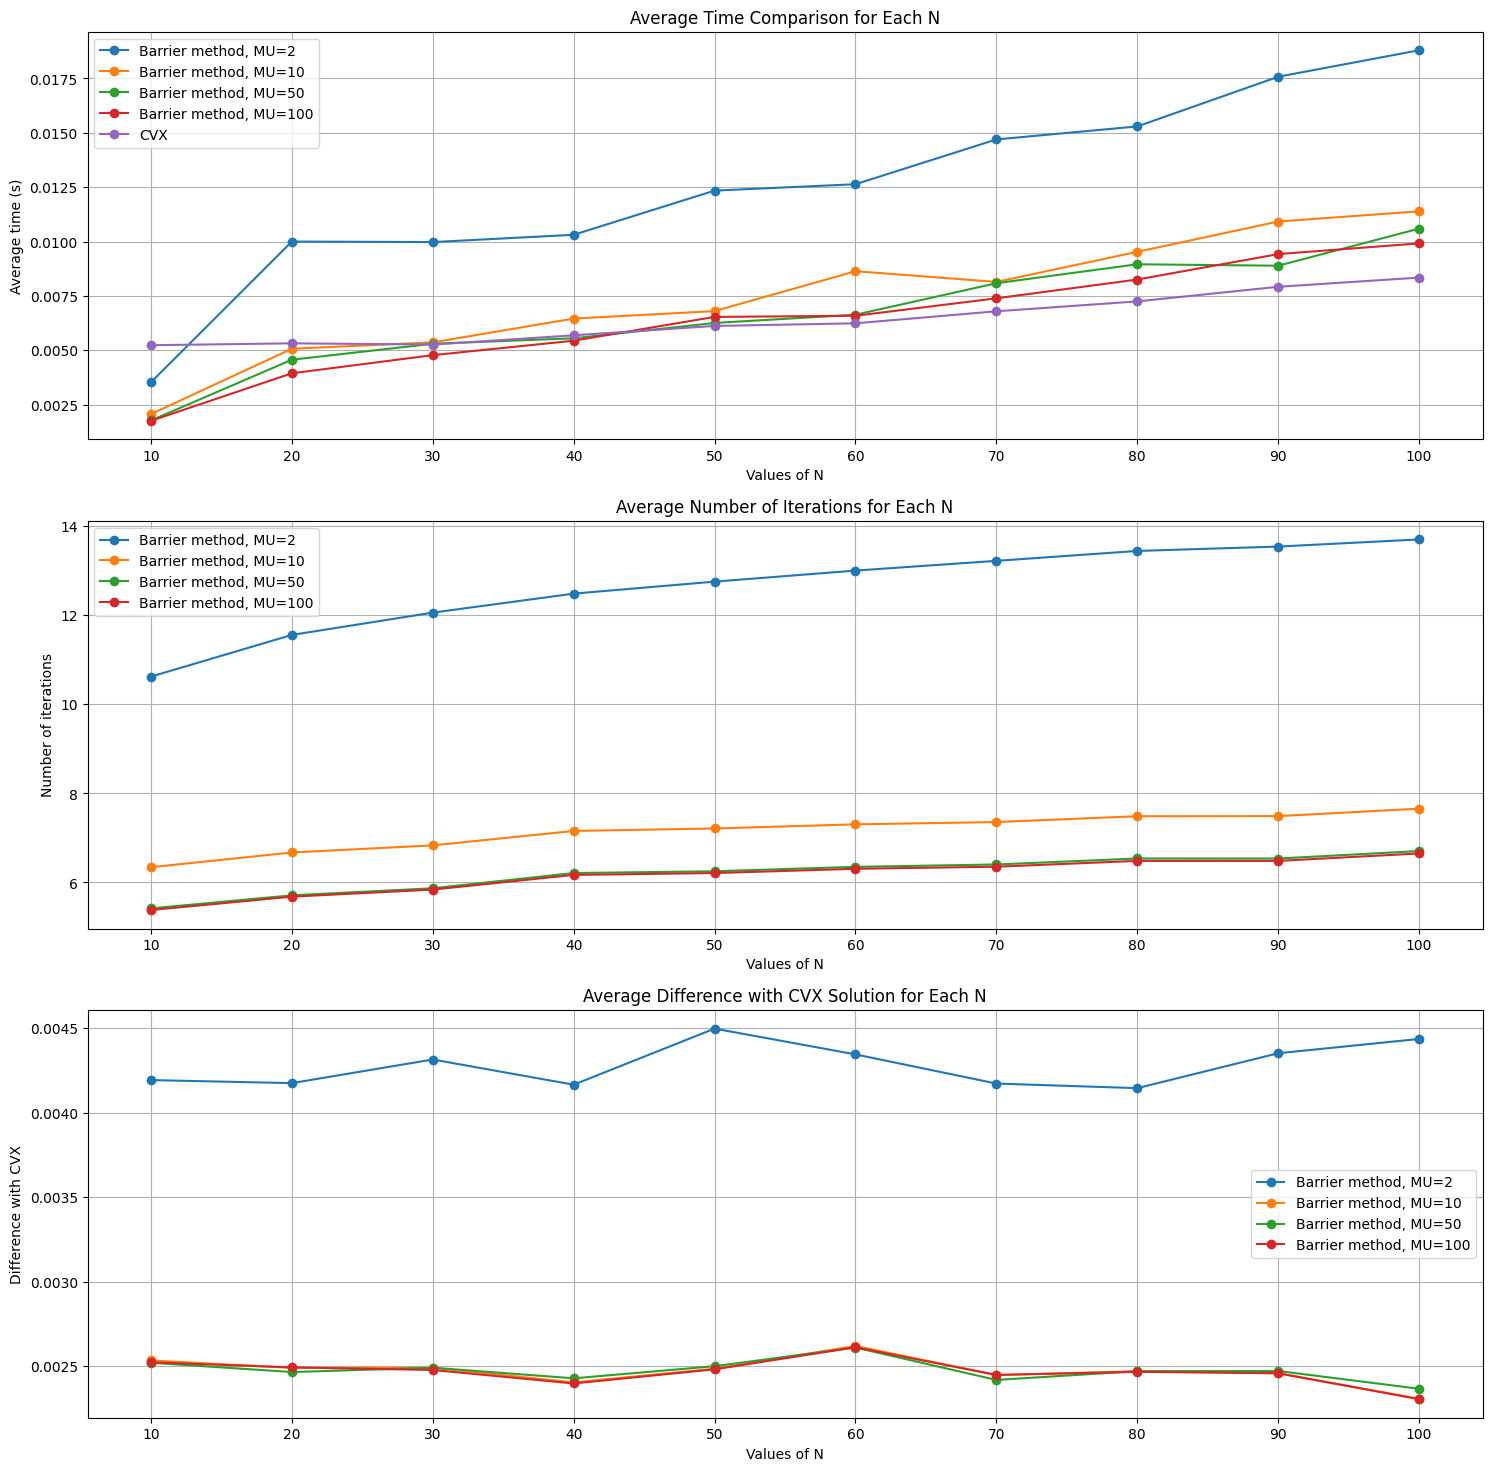

In [228]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

fig, axes = plt.subplots(3, 1, figsize=(18, 18))
for mu in mu_list:
    axes[0].plot(dimensions, [sum(mu_barrier_time[mu][n])/len(mu_barrier_time[mu][n]) for n in dimensions], label=f'Barrier method, MU={mu}', marker='o', linestyle='-')
axes[0].plot(dimensions, [sum(cvx_time[n])/len(cvx_time[n]) for n in dimensions], label='CVX', marker='o', linestyle='-')
axes[0].set_xlabel('Values of N')
axes[0].set_ylabel('Average time (s)')
axes[0].set_title('Average Time Comparison for Each N')
axes[0].legend()
axes[0].grid(True)
axes[0].set_xticks(dimensions)

for mu in mu_list:
    axes[1].plot(dimensions, [sum(mu_barrier_iters[mu][n])/len(mu_barrier_iters[mu][n]) for n in dimensions], label=f'Barrier method, MU={mu}', marker='o', linestyle='-')
axes[1].set_xlabel('Values of N')
axes[1].set_ylabel('Number of iterations')
axes[1].set_title('Average Number of Iterations for Each N')
axes[1].legend()
axes[1].grid(True)
axes[1].set_xticks(dimensions)

for mu in mu_list:
    axes[2].plot(dimensions, [sum(mu_barrier_eps[mu][n])/len(mu_barrier_eps[mu][n]) for n in dimensions], label=f'Barrier method, MU={mu}', marker='o', linestyle='-')
axes[2].set_xlabel('Values of N')
axes[2].set_ylabel('Difference with CVX')
axes[2].set_title('Average Difference with CVX Solution for Each N')
axes[2].legend()
axes[2].grid(True)
axes[2].set_xticks(dimensions)